Setup and Imports

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
import seaborn as sns
import matplotlib.pyplot as plt

Define Data Paths

In [ ]:
DATA_DIR = "data/lisa"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")

print("Train classes:", os.listdir(TRAIN_DIR))
print("Val classes:", os.listdir(VAL_DIR))

Train classes: ['green', 'red', 'yellow']
Val classes: ['green', 'red', 'yellow']


Classical Machine Learning Pipeline

Feature Extraction

In [ ]:
def extract_color_hist(image, bins=(8,8,8)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0,1,2], None, bins, [0,256,0,256,0,256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_hog_features(image, resize=(64,64)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, resize)
    return hog(
        gray,
        orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys',
        transform_sqrt=True,
        feature_vector=True
    )

def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    return np.hstack([extract_color_hist(img), extract_hog_features(img)])

Extract Classical Features for Dataset Folder

In [ ]:
def extract_dataset_features(folder):
    X, y = [], []
    for label in os.listdir(folder):
        class_dir = os.path.join(folder, label)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            if not img_name.lower().endswith((".jpg",".png")):
                continue
            path = os.path.join(class_dir, img_name)
            try:
                feats = extract_features(path)
                X.append(feats)
                y.append(label)
            except:
                continue
    return np.array(X), np.array(y)

Load and Extract Classical Features

In [ ]:
print("Extracting training features...")
X_train, y_train = extract_dataset_features(TRAIN_DIR)

print("Extracting validation features...")
X_val, y_val = extract_dataset_features(VAL_DIR)

print("Feature vector size:", X_train.shape[1])
print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))

Extracting training features...
Extracting validation features...
Feature vector size: 2276
Training samples: 37085
Validation samples: 10346


Train Classical ML Models

In [7]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "SVM": SVC(kernel='rbf', C=10),
    "Random Forest": RandomForestClassifier(n_estimators=150),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    predictions[name] = y_pred
    
    print(classification_report(y_val, y_pred))
    results[name] = (y_pred == y_val).mean()



Training SVM...
              precision    recall  f1-score   support

       green       1.00      1.00      1.00      4823
         red       1.00      1.00      1.00      5244
      yellow       1.00      0.89      0.94       279

    accuracy                           1.00     10346
   macro avg       1.00      0.96      0.98     10346
weighted avg       1.00      1.00      1.00     10346


Training Random Forest...
              precision    recall  f1-score   support

       green       1.00      1.00      1.00      4823
         red       0.99      1.00      1.00      5244
      yellow       0.99      0.84      0.91       279

    accuracy                           0.99     10346
   macro avg       0.99      0.94      0.97     10346
weighted avg       0.99      0.99      0.99     10346


Training KNN...
              precision    recall  f1-score   support

       green       0.95      0.97      0.96      4823
         red       0.97      0.96      0.97      5244
      yellow  

Classical ML - Confusion Matrix Visualization

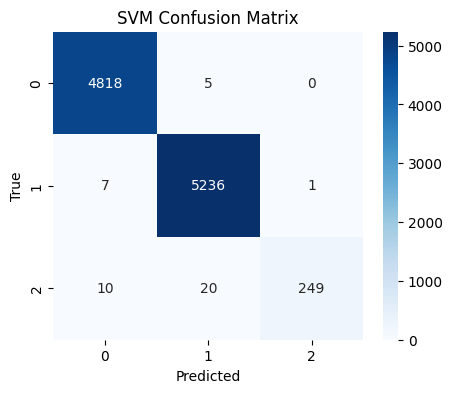

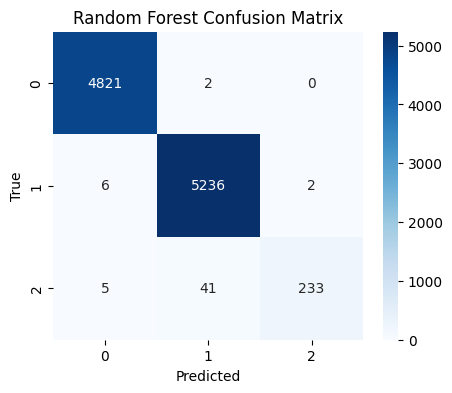

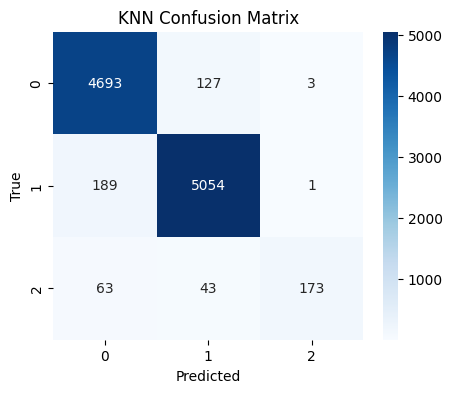

In [9]:
for name, y_pred in predictions.items():
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Convolutional Neural Network Pipeline

CNN Transforms and Data Loader

In [8]:
IMAGE_SIZE = 64
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ColorJitter(0.4, 0.4, 0.4),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(VAL_DIR,   transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
class_names

['green', 'red', 'yellow']

Define CNN Model

In [10]:
class TrafficCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

CNN Training Loop

In [11]:
EPOCHS = 10
history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    history.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} — Loss: {avg_loss:.4f}")

Epoch 1/10 — Loss: 0.0663
Epoch 2/10 — Loss: 0.0323
Epoch 3/10 — Loss: 0.0227
Epoch 4/10 — Loss: 0.0237
Epoch 5/10 — Loss: 0.0234
Epoch 6/10 — Loss: 0.0215
Epoch 7/10 — Loss: 0.0189
Epoch 8/10 — Loss: 0.0171
Epoch 9/10 — Loss: 0.0160
Epoch 10/10 — Loss: 0.0142


CNN Evaluation

In [12]:
model.eval()
preds, true = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        preds.extend(predicted.cpu().numpy())
        true.extend(labels.numpy())

print("Classification Report:")
print(classification_report(true, preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       green       1.00      1.00      1.00      4823
         red       0.99      1.00      0.99      5244
      yellow       0.99      0.82      0.90       279

    accuracy                           0.99     10346
   macro avg       0.99      0.94      0.96     10346
weighted avg       0.99      0.99      0.99     10346



CNN Confusion Matrix

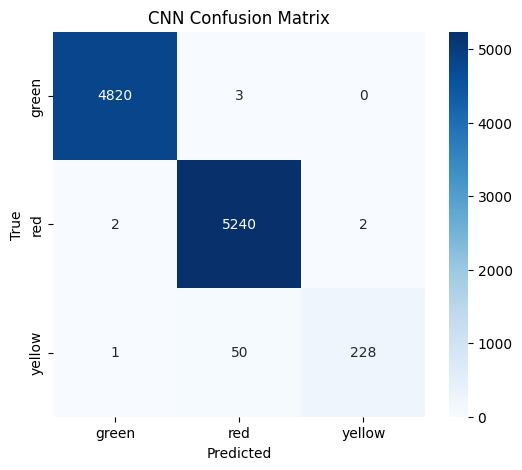

In [13]:
cm = confusion_matrix(true, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Save CNN Model

In [14]:
torch.save(model.state_dict(), "cnn_model.pth")
print("Saved cnn_model.pth")

Saved cnn_model.pth
